In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hnswlib
from sklearn.neighbors import NearestNeighbors
from heapq import heappush, heappop

In [2]:

# Path to your GloVe file (update this based on your downloaded version)
glove_path = '/Users/tanishqchaudhari/Desktop/DataScience Proj  datasets/Dataset/glove.6B.100d.txt'

# Load GloVe vectors
word_to_vec = {}
words = []
vectors = []

with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]  # First token is the word
        vector = np.array(values[1:], dtype=np.float32)  # Rest are vector values
        word_to_vec[word] = vector
        words.append(word)
        vectors.append(vector)

# Convert to numpy array
vectors = np.array(vectors, dtype=np.float32)
print(f"Loaded {len(words)} word vectors of dimension {vectors.shape[1]}")

Loaded 400000 word vectors of dimension 100


In [25]:
dim = vectors.shape[1]  # Embedding dimension
num_elements = len(words)  # Number of words

# Initialize HNSW index
hnsw_index = hnswlib.Index(space="l2", dim=dim)  # "l2" is Euclidean distance

# Set up the index
hnsw_index.init_index(max_elements=num_elements, ef_construction=200, M=16)

# Add word vectors to the index
hnsw_index.add_items(vectors)

print("HNSW index built successfully!")

HNSW index built successfully!


In [26]:
def find_similar_words(query_word, k=6):
    if query_word not in word_to_vec:
        return f"'{query_word}' not found in vocabulary!"

    query_vector = word_to_vec[query_word].reshape(1, -1)
    labels, distances = hnsw_index.knn_query(query_vector, k=k)

    print(f"\nTop {k} words similar to '{query_word}':")
    for i, index in enumerate(labels[0]):
        print(f"{i+1}. {words[index]} (Distance: {distances[0][i]:.4f})")

In [30]:
# Example Query
find_similar_words("king", k=15)


Top 15 words similar to 'king':
1. king (Distance: 0.0000)
2. prince (Distance: 16.7458)
3. queen (Distance: 18.3291)
4. monarch (Distance: 20.0182)
5. brother (Distance: 20.5814)
6. uncle (Distance: 21.7993)
7. nephew (Distance: 22.0494)
8. son (Distance: 22.1171)
9. throne (Distance: 22.3965)
10. kingdom (Distance: 22.5374)
11. reign (Distance: 22.7267)
12. henry (Distance: 23.0660)
13. father (Distance: 23.2027)
14. crown (Distance: 23.3006)
15. cousin (Distance: 23.3255)


# Using cosine

In [7]:

dim = vectors.shape[1]  # Embedding dimension
num_elements = len(words)  # Number of words

# Initialize HNSW index
hnsw_index_cosine = hnswlib.Index(space="cosine", dim=dim)  # "l2" is Euclidean distance

# Set up the index
hnsw_index_cosine.init_index(max_elements=num_elements, ef_construction=200, M=16)

# Add word vectors to the index
hnsw_index_cosine.add_items(vectors)

print("HNSW index built successfully!")

HNSW index built successfully!


In [8]:
def find_similar_words_cosine(query_word, k=6):
    if query_word not in word_to_vec:
        return f"'{query_word}' not found in vocabulary!"

    query_vector = word_to_vec[query_word].reshape(1, -1)
    labels, distances = hnsw_index_cosine.knn_query(query_vector, k=k)

    print(f"\nTop {k} words similar to '{query_word}':")
    for i, index in enumerate(labels[0]):
        print(f"{i+1}. {words[index]} (Distance: {distances[0][i]:.4f})")

In [29]:
for a in range(1):
    find_similar_words_cosine("king", k=15)


Top 15 words similar to 'king':
1. king (Distance: -0.0000)
2. prince (Distance: 0.2318)
3. queen (Distance: 0.2492)
4. son (Distance: 0.2979)
5. brother (Distance: 0.3014)
6. monarch (Distance: 0.3022)
7. throne (Distance: 0.3080)
8. kingdom (Distance: 0.3189)
9. emperor (Distance: 0.3287)
10. ii (Distance: 0.3324)
11. crown (Distance: 0.3352)
12. reign (Distance: 0.3370)
13. uncle (Distance: 0.3392)
14. henry (Distance: 0.3422)
15. ruler (Distance: 0.3461)


In [11]:
from tqdm import tqdm

In [12]:
# Step 1: Generate 10^5 random query indices
num_queries = 10**5
query_indices = np.random.randint(0, len(words), size=num_queries)

# Step 2: Get the corresponding query vectors
query_vectors = vectors[query_indices]

# Step 3: Use NearestNeighbors to find 100 nearest neighbors
k = 100
nn = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='l2')
nn.fit(vectors)

# Step 4: For each query, get the indices of the 100 nearest neighbors
distances, neighbor_indices = nn.kneighbors(query_vectors)

# Step 5: Store results in a dictionary {query_word: [neighbor_words]}
query_to_neighbors = {}



# Step 5: Store results in a dictionary {query_word: [neighbor_words]}
query_to_neighbors = {}
for i in tqdm(range(len(query_indices)), desc="Finding nearest neighbors"):
    query_idx = query_indices[i]
    query_word = words[query_idx]
    neighbor_words = [words[idx] for idx in neighbor_indices[i]]
    query_to_neighbors[query_word] = neighbor_words

print(f"Stored nearest neighbors for {len(query_to_neighbors)} queries.")


Finding nearest neighbors: 100%|██████████| 100000/100000 [00:00<00:00, 111452.76it/s]

Stored nearest neighbors for 88617 queries.


In [34]:
neighbor_embeddings = vectors[neighbor_indices]

In [36]:
neighbor_embeddings.shape

(100000, 100, 100)

In [37]:
import json

with open("query_neighbors.json", "w") as f:
    json.dump(query_to_neighbors, f)



In [38]:
import json

# Load the saved query-to-neighbors mapping
with open("query_neighbors.json", "r") as f:
    query_to_neighbors = json.load(f)

print(f"Loaded {len(query_to_neighbors)} queries from file.")

# Step 6: Create a dictionary mapping each unique query_word to its vector
query_word_vectors = {word: word_to_vec[word] for word in query_to_neighbors}

print(f"Stored vectors for {len(query_word_vectors)} unique query words.")



Loaded 88617 queries from file.
Stored vectors for 88617 unique query words.


In [39]:
query_to_neighbors_vectors = {}

for i in tqdm(range(len(query_indices)), desc="Finding nearest neighbors"):
    query_idx = query_indices[i]
    neighbor_indices_list = neighbor_indices[i]
    query_to_neighbors_vectors[query_idx] = neighbor_indices_list  # All indices, not vectors


Finding nearest neighbors: 100%|██████████| 100000/100000 [00:00<00:00, 2469780.07it/s]


In [40]:
from collections import Counter
import pandas as pd

# Flatten all neighbor indices into a single list
all_neighbors = [idx for neighbors in query_to_neighbors_vectors.values() for idx in neighbors]

# Count frequency of each neighbor index
freq_counter = Counter(all_neighbors)

# Create DataFrame and sort
freq_df = pd.DataFrame(freq_counter.items(), columns=["Index", "Frequency"]).sort_values("Frequency", ascending=False)



collections.Counter

In [41]:
print(len(all_neighbors))


8861700


In [42]:
print(freq_df.head())  # Preview
print(freq_df.tail())  # Preview

       Index  Frequency
1324  154957      10205
1359  289249      10085
770   364978       9272
795   224673       8915
1302  262208       7260
         Index  Frequency
173016  311938          1
173015  128910          1
319309  144392          1
319310  173704          1
361390  228487          1


In [43]:
#printing the average
average = freq_df["Frequency"].mean()
print(f"Average frequency of neighbors: {average}")

Average frequency of neighbors: 24.521086579355877


In [44]:
print(len(freq_df))  # Total unique neighbors

361391


In [45]:
print(len(freq_df))  # Total unique neighbors

361391


In [53]:
def compute_hubs(
    neighbor_indices: np.ndarray,
    distances:        np.ndarray,
    freq_df:          pd.DataFrame,
    alpha:            float = 0.5,
    method:           str   = "percentile",
    threshold:        float = 95.0,
    top_k:            int   = None
) -> (pd.Series, set):
    """
    Compute combined hub‐scores f_i and select hub items H.

    Inputs:
      - neighbor_indices: shape (5000,100) np.int array of item‑IDs
      - distances:        shape (5000,100) np.float array of distances
      - freq_df:          pd.DataFrame with columns ["Index","Frequency"]
                          where Frequency = c_i = #queries whose top‑100 includes item i
      - alpha:            weight in [0,1] between freq and distance
      - method:           "percentile", "top_k", or "stddev"
      - threshold:        percentile p (if method="percentile"), or
                          k (if method="stddev" meaning μ + k·σ)
      - top_k:            required if method="top_k"

    Returns:
      - combined:   pd.Series indexed by item‑ID, values f_i ∈ [0,1]
      - hub_set:    set of item‑IDs chosen as hubs
    """

    # --- 1) Normalize frequency via min–max over c_i ---
    # freq_df["Index"] holds item‑IDs, freq_df["Frequency"] holds c_i
    freq_series = freq_df.set_index("Index")["Frequency"].astype(float)
    c_min, c_max = freq_series.min(), freq_series.max()
    if c_max > c_min:
        f_freq = (freq_series - c_min) / (c_max - c_min)
    else:
        f_freq = pd.Series(0.0, index=freq_series.index)

    # --- 2) Compute average distance d̄_i and normalize/flip to get f_dist ---
    df = pd.DataFrame({
        "Index":    neighbor_indices.ravel(),
        "Distance": distances.ravel()
    })
    d_bar = df.groupby("Index")["Distance"].mean()
    d_min, d_max = d_bar.min(), d_bar.max()
    if d_max > d_min:
        d_tilde = (d_bar - d_min) / (d_max - d_min)
    else:
        d_tilde = pd.Series(0.0, index=d_bar.index)
    f_dist = 1.0 - d_tilde

    # --- 3) Combine scores on the intersection of items ---
    common = f_freq.index.intersection(f_dist.index)
    combined = alpha * f_freq.loc[common] + (1 - alpha) * f_dist.loc[common]
    combined.name = "f_i"

    # --- 4) Select hubs ---
    if method == "percentile":
        cutoff = np.percentile(combined.values, threshold)
        hub_set = set(combined[combined >= cutoff].index)

    elif method == "stddev":
        mu, sigma = combined.mean(), combined.std()
        cutoff = mu + threshold * sigma
        hub_set = set(combined[combined >= cutoff].index)

    elif method == "top_k":
        if top_k is None:
            raise ValueError("top_k must be provided when method='top_k'")
        hub_set = set(combined.nlargest(top_k).index)

    else:
        raise ValueError(f"unknown method {method!r}")

    return combined, hub_set

# ------------------------------
# Example usage:

# neighbor_indices = np.load("neighbor_indices.npy")   # shape (5000,100)
# distances        = np.load("distances.npy")          # shape (5000,100)
# freq_df          = pd.read_csv("freq_df.csv")        # columns: Index, Frequency

# combined_scores, hubs = compute_hubs(
#     neighbor_indices,
#     distances,
#     freq_df,
#     alpha=0.5,
#     method="percentile",
#     threshold=95.0
# )

# print(f"Computed {len(combined_scores):,} scores; selected {len(hubs):,} hubs.")


In [54]:
combined_scores, hubs = compute_hubs(
    neighbor_indices,
    distances,
    freq_df,
    alpha=0.5,
    method="percentile",
    threshold=95.0
)

In [79]:
combined_scores.values[:30]

array([0.87194368, 0.86849778, 0.82909789, 0.80806522, 0.73288641,
       0.69177807, 0.66899318, 0.6350138 , 0.60916277, 0.59911915,
       0.58193594, 0.52846831, 0.53711434, 0.54688352, 0.54489948,
       0.5400565 , 0.52562198, 0.49340704, 0.41356177, 0.51776247,
       0.41335868, 0.41169724, 0.41362197, 0.41151093, 0.41071292,
       0.409581  , 0.40836999, 0.41605013, 0.41631664, 0.40831122])

In [80]:
combined_scores.index[:29]

Index([154957, 289249, 364978, 224673, 262208, 362063, 343094,  87659, 330934,
       123886, 202665, 370973, 373527, 292240,  71873, 393850, 379304, 331160,
       318189, 379961, 282800, 353522, 262183, 223065, 350823, 114807, 338189,
       297409, 367899],
      dtype='int64', name='Index')

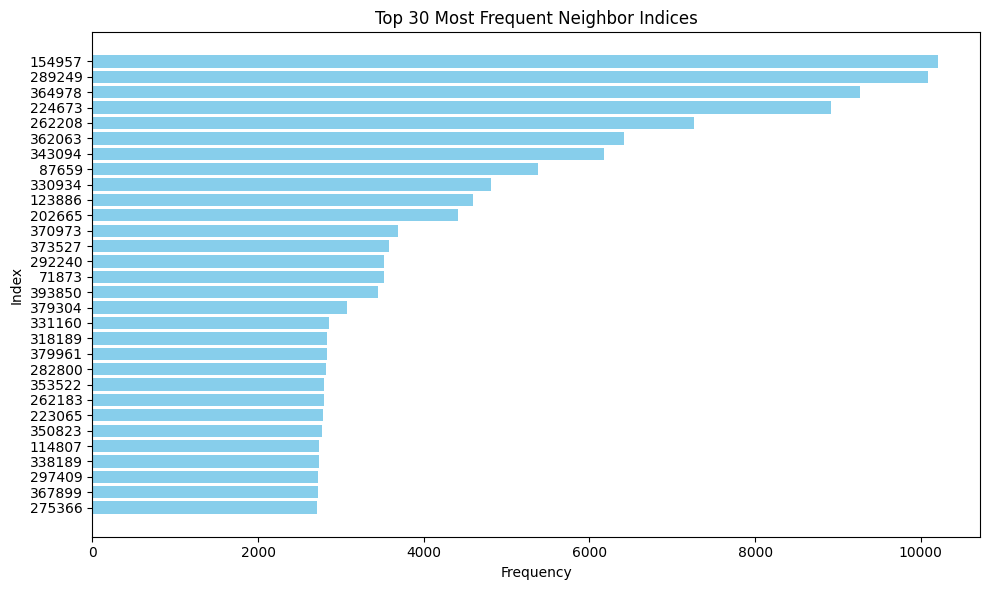

In [57]:
import matplotlib.pyplot as plt
import squarify  # pip install squarify if not already installed
import numpy as np

# Select top N most frequent indices
top_n = 30
freq_top = freq_df.head(top_n)

# 1. Horizontal Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(freq_top["Index"].astype(str), freq_top["Frequency"], color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Index")
plt.title(f"Top {top_n} Most Frequent Neighbor Indices")
plt.gca().invert_yaxis()  # Highest freq on top
plt.tight_layout()
plt.show()

# # 3. Cumulative Frequency Line Plot
# freq_df_sorted = freq_df.sort_values("Frequency", ascending=False)
# cum_freq = np.cumsum(freq_df_sorted["Frequency"])
# cum_freq = cum_freq / cum_freq.max()  # Normalize to 0–1

# plt.figure(figsize=(10, 4))
# plt.plot(range(len(cum_freq)), cum_freq, marker='o', linestyle='-', color='green')
# plt.title("Cumulative Frequency of Neighbor Indices")
# plt.xlabel("Index Rank")
# plt.ylabel("Cumulative Frequency (Normalized)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [71]:
freq_top["Index"].astype(str).shape

(30,)

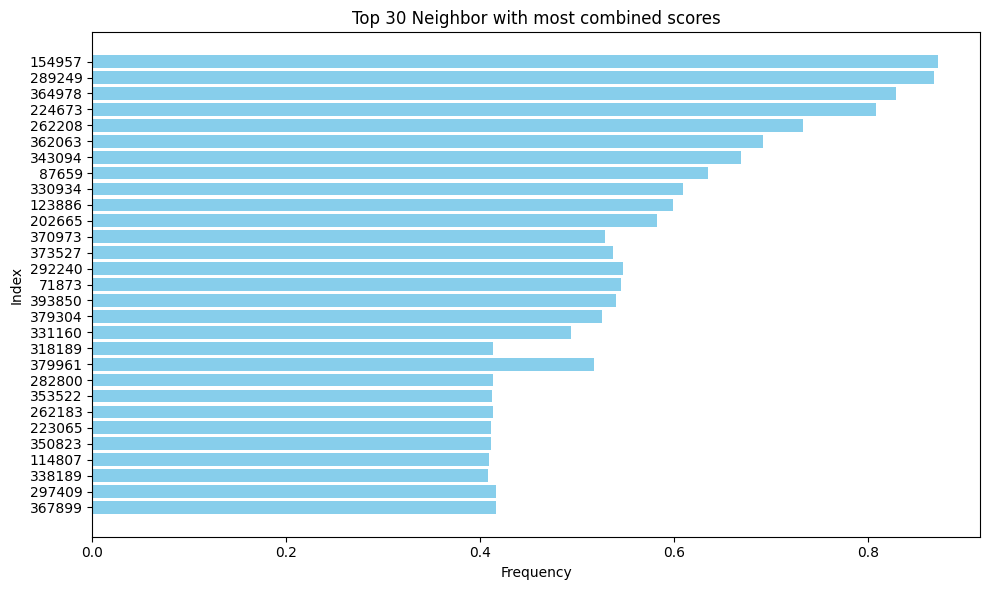

In [82]:
plt.figure(figsize=(10, 6))
plt.barh(combined_scores.index[:29].astype(str),combined_scores.values[:29], color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Index")
plt.title(f"Top {top_n} Neighbor with most combined scores")
plt.gca().invert_yaxis()  # Highest freq on top
plt.tight_layout()
plt.show()
